In [2]:
import warnings
from pylj import comp, md, sample, util
import numpy as np

warnings.filterwarnings('ignore')

In [3]:
def md_simulation(number_of_particles, temperature, box_length, number_of_steps, sample_frequency):
    # Creates the visualisation environment
    %matplotlib notebook
    # Initialise the system
    system = md.initialise(number_of_particles, temperature, box_length, 'square')
    # This sets the sampling class
    sample_system = sample.Interactions(system)
    # Start at time 0
    system.time = 0
    # Begin the molecular dynamics loop
    for i in range(0, number_of_steps):
        # At each step, calculate the forces on each particle 
        # and get acceleration
        system.particles, system.distances, system.forces = comp.compute_forces(system.particles, 
                                                                                system.distances,
                                                                                system.forces, system.box_length)
        # Run the equations of motion integrator algorithm
        system.particles = md.velocity_verlet(system.particles, system.timestep_length, system.box_length)
        # Sample the thermodynamic and structural parameters of the system
        system = md.sample(system.particles, system.box_length, system.initial_particles, system)
        # Allow the system to interact with a heat bath
        system.particles = comp.heat_bath(system.particles, system.temperature_sample, temperature)
        # Iterate the time
        system.time += system.timestep_length
        system.step += 1
        # At a given frequency sample the positions and plot the RDF
        if system.step % sample_frequency == 0:
            sample_system.update(system)
    return system

In [ ]:
system = md_simulation(100, 273.15, 30, 50000, 100)

In [1]:
particles = np.logspace(0, 8, 8, base=2, dtype=int)
print(particles)
pressure_array = np.zeros_like(particles, dtype=float)
pressure_error = np.zeros_like(particles, dtype=float)
for i in range(0, len(particles)):
    system = md_simulation(particles[i], 273.15, 100, 50000, 100)
    pressure_array[i] = np.average(system.pressure_sample)
    pressure_error[i] = np.std(system.pressure_sample)

NameError: name 'np' is not defined

In [8]:
print(pressure_array)

[3.77086843e-05 1.51521051e-04 6.24980601e-04 2.73738965e-03
 1.72779017e-02]


In [9]:
def vdw(particles, a, b):
    top = particles * 1.3806e-23 * 273.15
    bottom = 30e-10 * 30e-10 - (particles / 6.022e23) * b
    other = particles * particles * a / (6.022e23 * 6.022e23 * 30e-10 * 30e-10 * 30e-10 * 30e-10)
    return top / bottom - other

(array([-7241582.65221032, -1940809.82761109]), array([[1.09829714e+11, 1.72253006e+11],
       [1.72253006e+11, 6.15981812e+11]]))


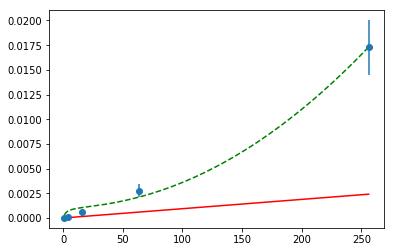

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import curve_fit

data = curve_fit(vdw, particles, pressure_array)
print(data)
x = np.logspace(0, 8, 200, base=2, dtype=int)

plt.errorbar(particles, pressure_array, marker='o', yerr=pressure_error, ls='')
plt.plot(particles, particles/(200e-10*200e-10) * 1.3806e-23 * 273.15, 'r-')
plt.plot(x, vdw(x, data[0][0], data[0][1]), 'g--')
plt.show()